# Triangle Prism Densities

This notebook demonstrates the application of `circle_bundles` to a synthetic dataset of 3D densities constructed from ...


In [1]:
# ============================================================
# Core scientific stack
# ============================================================
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# circle_bundles core API
# ============================================================
import circle_bundles as cb
import circle_bundles.synthetic as sy
import circle_bundles.viz as vz


First, construct a template mesh to use to generate the density dataset:

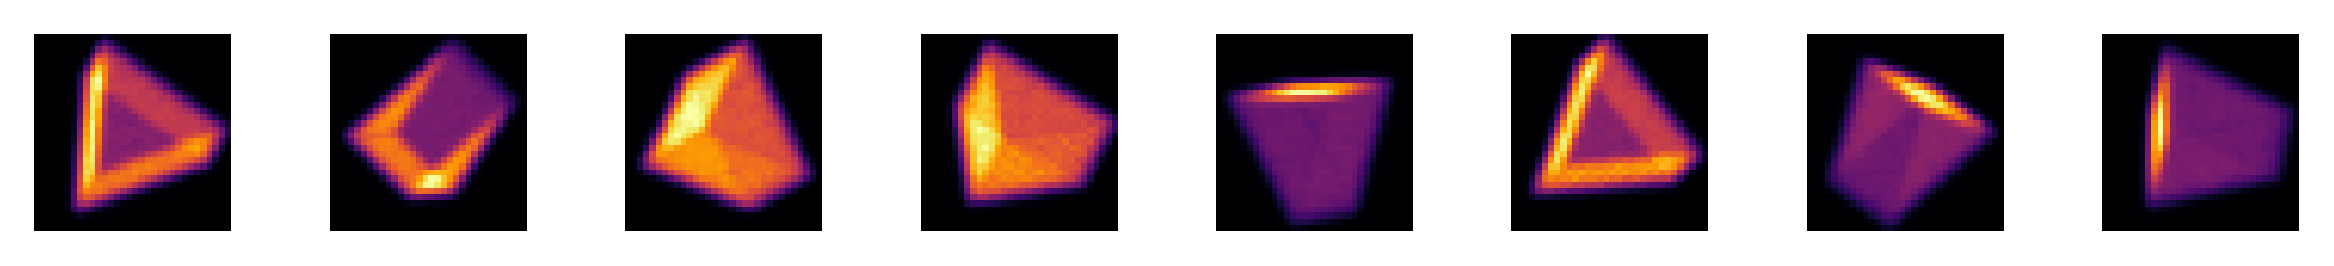

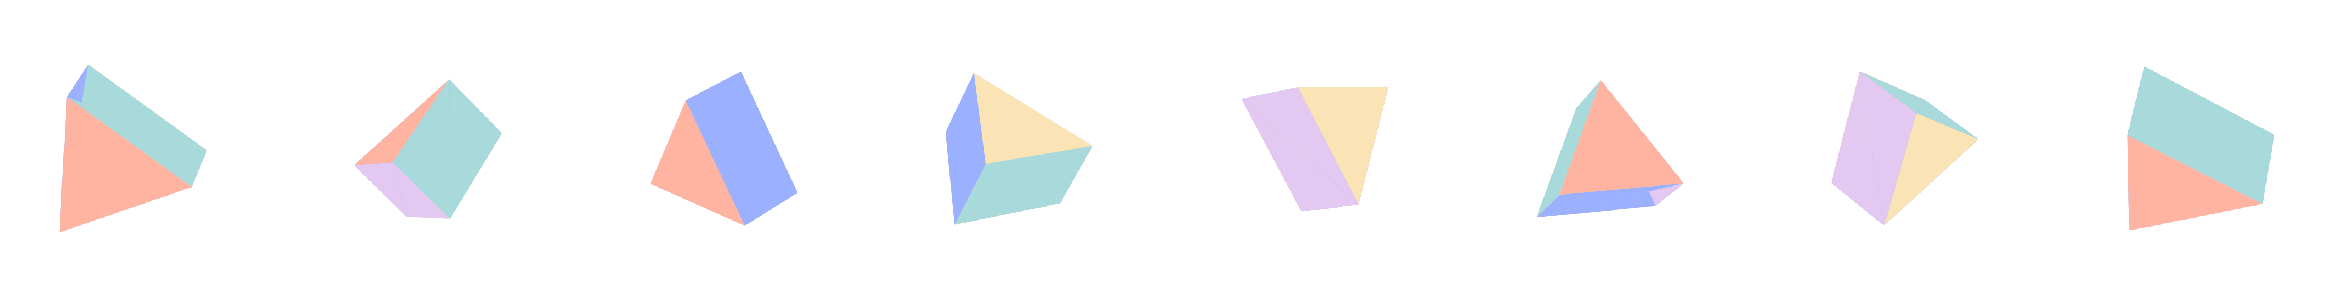

In [10]:
#Create the template triangle mesh
mesh, face_groups = sy.make_tri_prism(height=1, radius=1)


grid_size = 32  #density resolution
sigma = 0.05  #density gaussian parameter

#Create visualization functions for triangle meshes and 3D densities
vis_density = sy.make_density_visualizer(grid_size=grid_size)
vis_mesh = sy.make_tri_prism_visualizer(mesh, face_groups)




Note that triangle meshes which differ by a rotation in the stabilizer subgroup of $\mathcal{O}_{\text{prism}}$ produce the same 3D density. 

Now, generate a synthetic dataset of 3D densities represented as vectors of length $[\text{grid_size}]^{3}$. Record the corresponding triangle meshes for visualization (represented as vectors in $\mathbb{R}^{18}$):

In [17]:
import numpy as np
import trimesh
from scipy.spatial import cKDTree

def _voxel_coords_minus1_to_1(grid_size: int) -> np.ndarray:
    lin = np.linspace(-1.0, 1.0, int(grid_size))
    X, Y, Z = np.meshgrid(lin, lin, lin, indexing="ij")
    return np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

def make_rotated_density_dataset_fast(
    mesh: trimesh.Trimesh,
    rotations: np.ndarray,
    *,
    grid_size: int = 32,
    sigma: float = 0.05,
    n_surface_samples: int = 2000,
    normalize: bool = True,
    batch_size: int = 16,   # important knob
    eps: float = 1e-12,
    rng: np.random.Generator | None = None,
) -> np.ndarray:
    grid_size = int(grid_size)
    sigma = float(sigma)

    rots = np.asarray(rotations, dtype=np.float64)
    if rots.ndim == 2 and rots.shape[1] == 9:
        rots = rots.reshape(-1, 3, 3)
    if rots.ndim != 3 or rots.shape[1:] != (3, 3):
        raise ValueError(f"rotations must be (n,9) or (n,3,3). Got {rots.shape}.")

    # ---- normalize mesh (same as your mesh_to_density) ----
    m = mesh.copy()
    m.apply_translation(-m.center_mass)
    scale = float(np.max(np.linalg.norm(m.vertices, axis=1)))
    if scale <= eps:
        raise ValueError("Mesh appears degenerate (near-zero scale).")
    m.apply_scale(0.99 / scale)

    # ---- sample surface once + KD-tree once ----
    _ = rng
    surface = m.sample(int(n_surface_samples))
    tree = cKDTree(surface)

    coords = _voxel_coords_minus1_to_1(grid_size).astype(np.float32)  # (D,3)
    D = coords.shape[0]
    n = rots.shape[0]
    out = np.empty((n, D), dtype=np.float32)

    inv_two_sigma2 = np.float32(1.0 / (2.0 * sigma * sigma))

    # SciPy parallelism knob changed names across versions; this is safe:
    def _query(points: np.ndarray) -> np.ndarray:
        try:
            dists, _ = tree.query(points, k=1, workers=-1)  # SciPy >= ~1.6
        except TypeError:
            dists, _ = tree.query(points, k=1)              # fallback
        return dists

    for a in range(0, n, batch_size):
        b = min(n, a + batch_size)
        R = rots[a:b]  # (B,3,3), float64

        # coords_rt = R^T coords, but build as one big (B*D,3) array
        # einsum gives (B,D,3) then reshape.
        coords_rt = np.einsum("bij,dj->bdi", R.transpose(0, 2, 1), coords).reshape(-1, 3)

        dists = _query(coords_rt).astype(np.float32)  # (B*D,)
        dens = np.exp(-(dists * dists) * inv_two_sigma2).reshape(b - a, D)

        if normalize:
            s = dens.sum(axis=1, keepdims=True)
            dens = np.divide(dens, np.maximum(s, np.float32(eps)), out=dens)

        out[a:b] = dens

    return out


In [18]:
n_samples = 5000
rng = np.random.default_rng(0)
R = sy.sample_so3(n_samples, rng=rng)[0]

mesh_data = sy.get_mesh_sample(mesh, R)
#data = sy.rotate_density(density, R, grid_size=grid_size)

data = make_rotated_density_dataset(
    mesh,
    R,
    grid_size = grid_size,
    sigma = sigma,
    n_surface_samples = 2000,
    rng = rng
)

View a small sample of the dataset, represented by 2D projections of the 3D densities and also by the triangle meshes used to produce the densities.

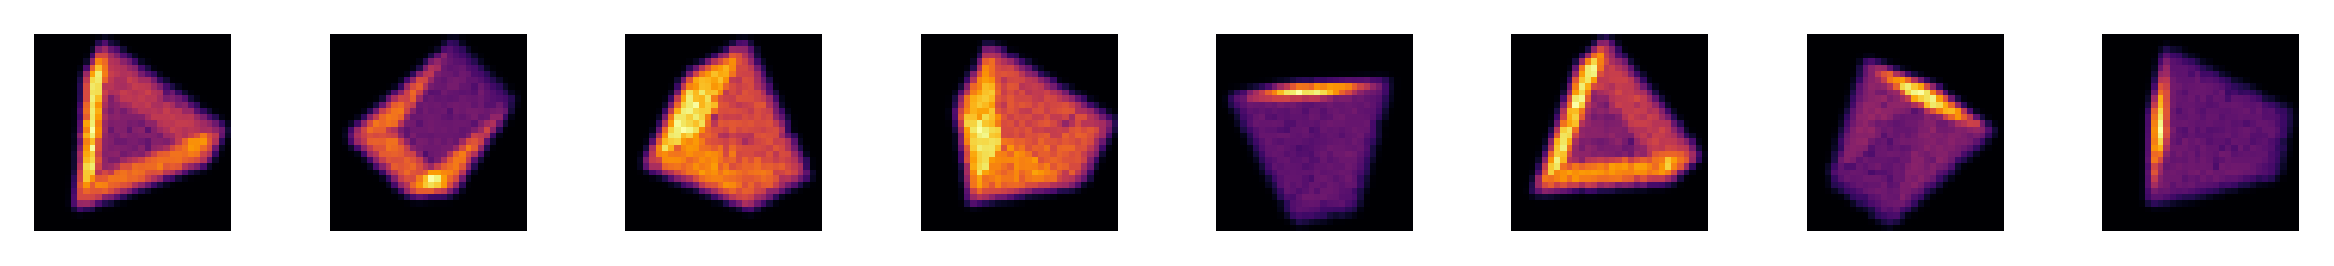

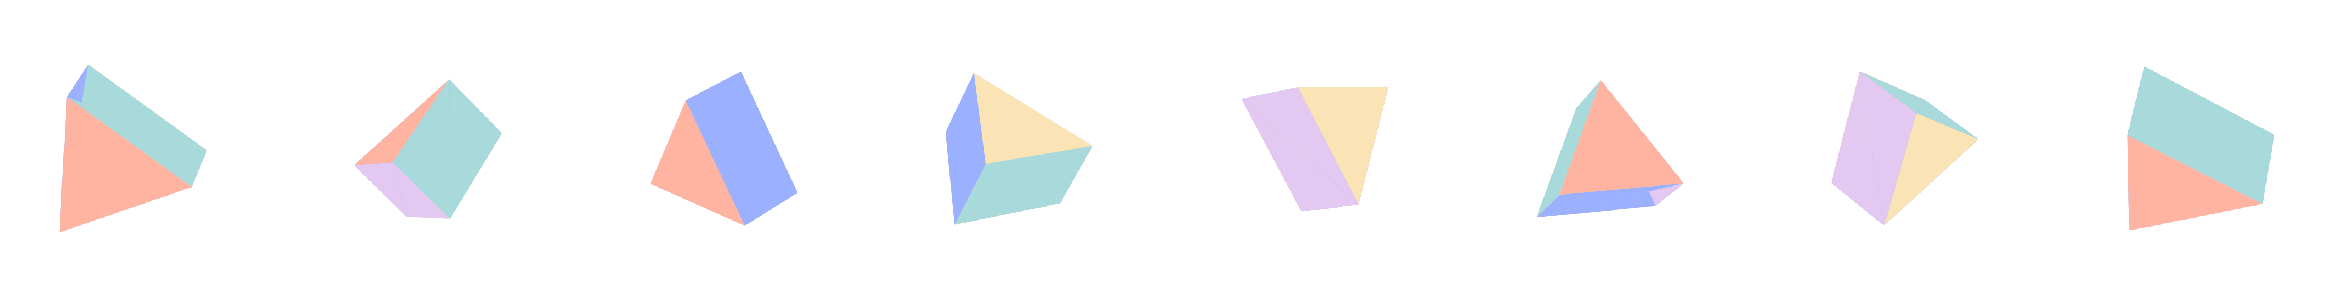

In [19]:
#View 2D projections of the resulting 3D densities
fig = vz.show_data_vis(
    data, 
    vis_density, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first")
plt.show()

#View the corresponding triangle meshes
fig = vz.show_data_vis(
    mesh_data, 
    vis_mesh, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first", 
    pad_frac=0.3)
plt.show()


Compute the base projections to $\mathbb{RP}^{2}$:

In [21]:
base_points = sy.get_density_axes(data)

Base projection coordinates computed.


Construct an open cover of $\mathbb{RP}^{2}$ using a collection of nearly equidistant landmark points (see reference):

### Cover And Nerve Summary
- $n_\text{sets} = 60$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 60$
- $\#(\text{1-simplices}) = 177$
- $\#(\text{2-simplices}) = 118$
- *No recorded simplices in dimensions* $\ge 3$

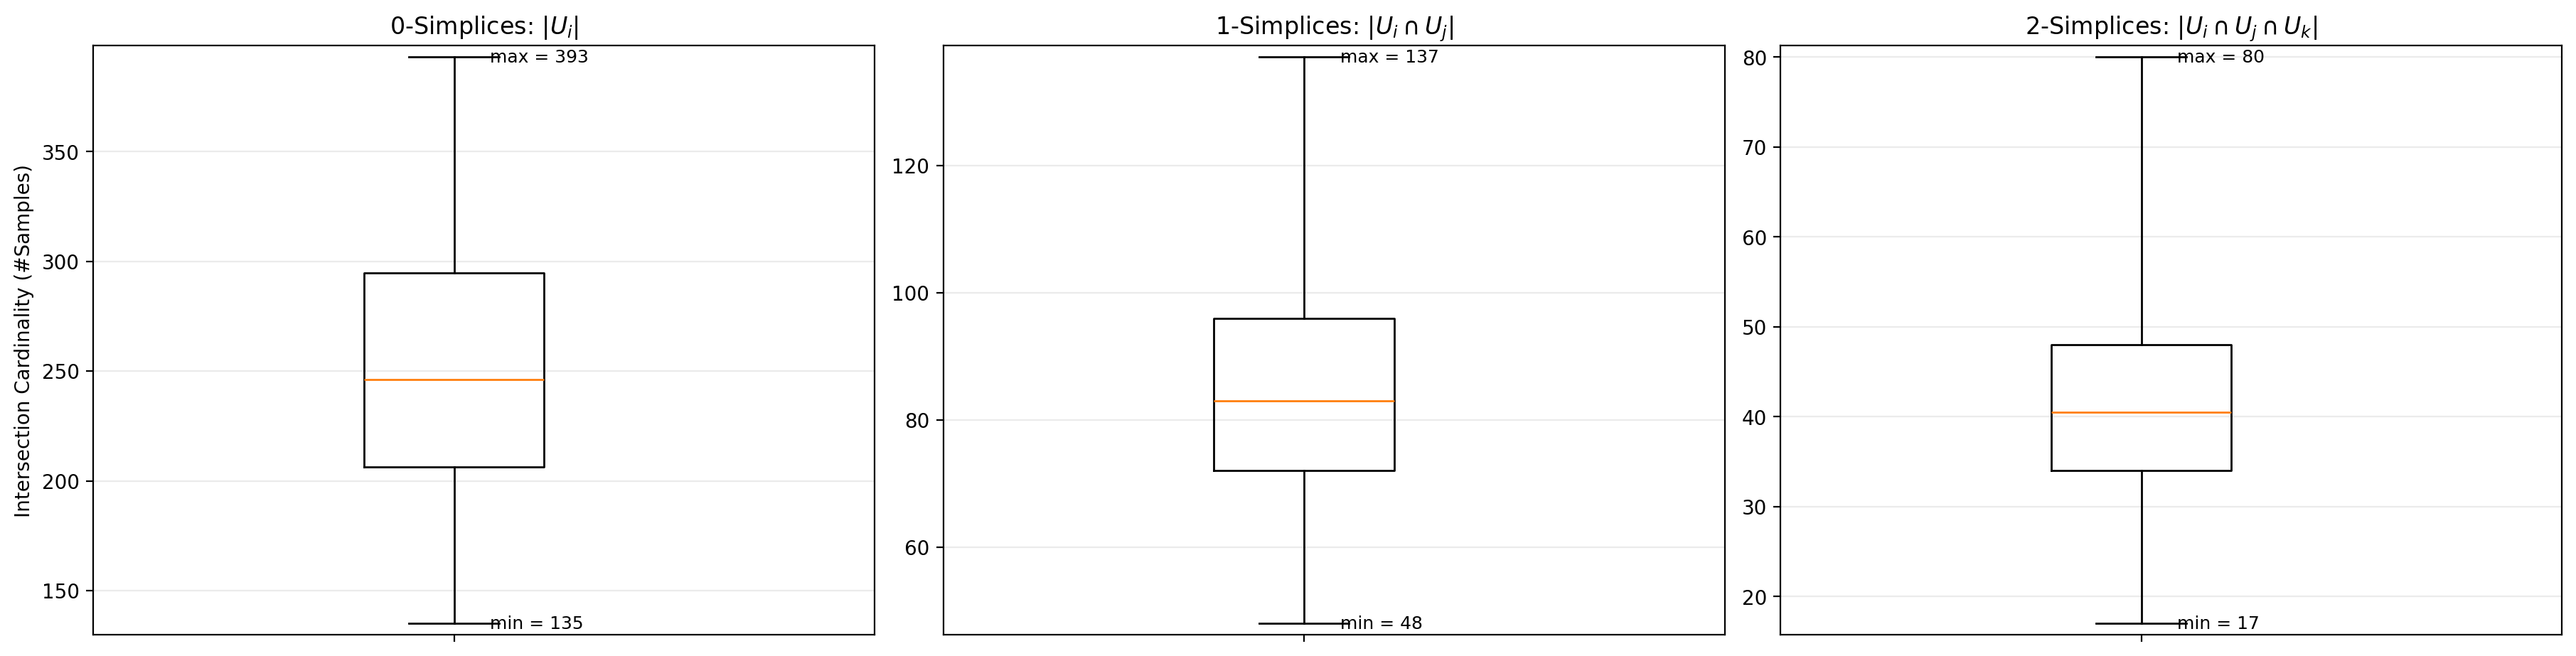

In [24]:
#Construct an open cover of RP2

n_landmarks = 60
cover = cb.make_rp2_fibonacci_star_cover(base_points, n_pairs = n_landmarks)

summ = cover.summarize(plot = True)


Optionally run the cell below to view a Plotly visualization of the nerve of the open cover:

In [26]:
fig = cover.show_nerve()

Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$

/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?



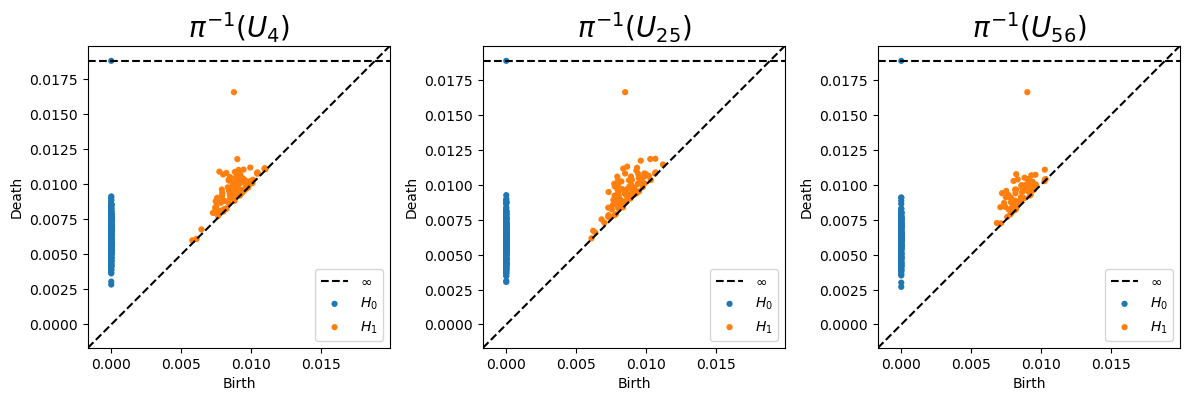

In [28]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [4,25,56], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Optionally run the cell below to show a visualization of a 'fat fiber' of the projection map:

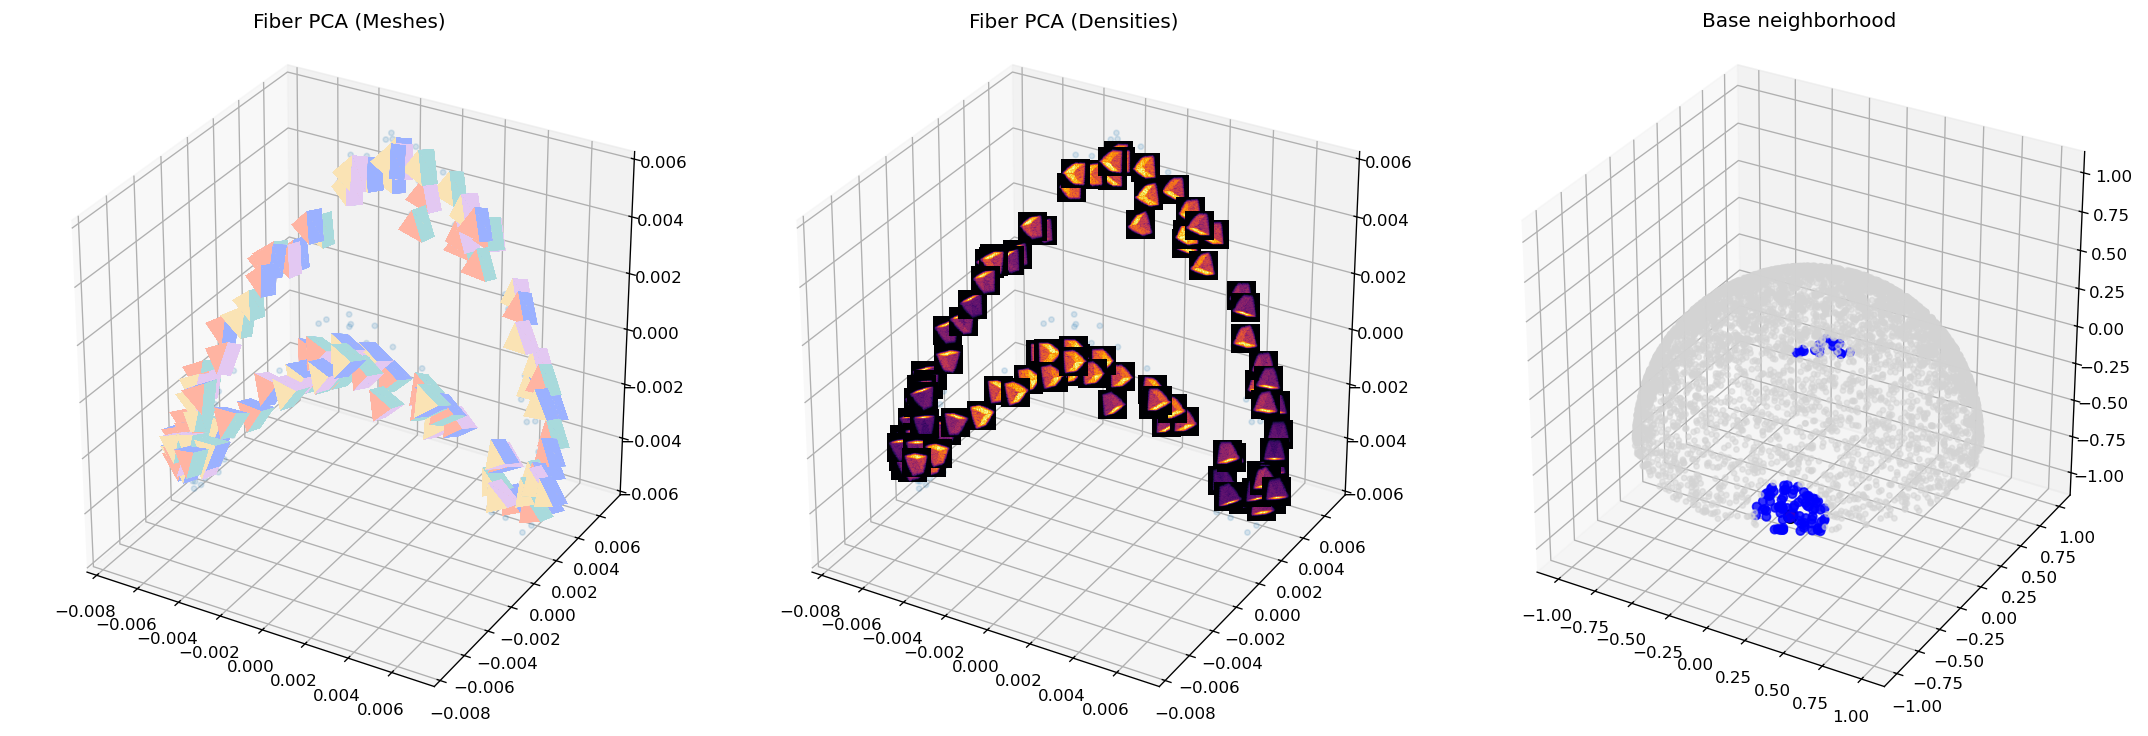

In [35]:
center_ind = 201
r = 0.2
dist_mat = cover.metric.pairwise(X=cover.base_points)
nearby_indices = np.where(dist_mat[center_ind] < r)[0]

fiber_data = data[nearby_indices]
vis_data = mesh_data[nearby_indices]


fig = plt.figure(figsize=(18, 6), dpi=120)
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

# PCA labeled with meshes
vz.fiber_vis(
    fiber_data,
    vis_mesh,
    vis_data=vis_data,
    max_images=200,
    zoom=0.08,
    ax=ax1,
    show=False,
)
ax1.set_title("Fiber PCA (Meshes)")

# PCA labeled with density projections
vz.fiber_vis(
    fiber_data,
    vis_func=vis_density,
    max_images=200,
    zoom=0.05,
    ax=ax2,
    show=False,
)
ax2.set_title("Fiber PCA (Densities)")

# Base visualization
vz.base_vis(
    cover.base_points,
    center_ind,
    r,
    dist_mat,
    ax=ax3,
    show=False,
)
ax3.set_title("Base neighborhood")

plt.tight_layout()
plt.show()


Compute local circular coordinates, approximate transition matrices and characteristic clases

In [37]:
bundle = cb.build_bundle(
    data,
    cover,
    show=True,                          
)


<IPython.core.display.Math object>

Show some correlations between local circular coordinates on overlaps

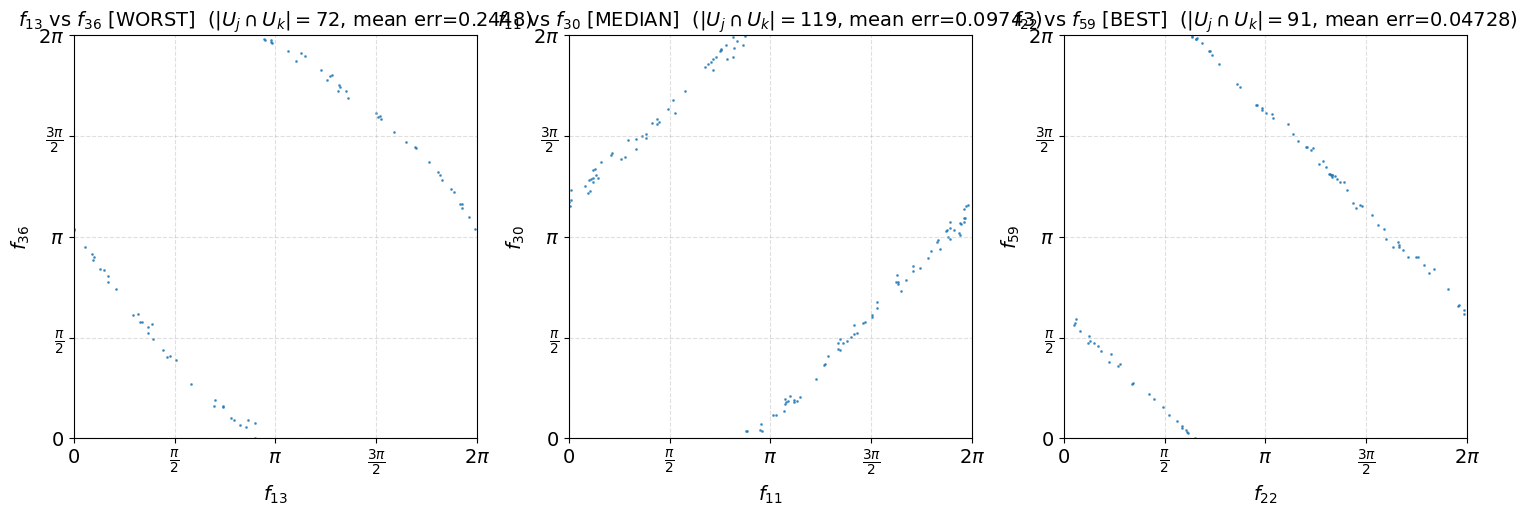

In [42]:
fig = bundle.compare_trivs(ncols = 3)
plt.show()

Compute class persistence on the weights filtration of the nerve

In [38]:
pers = bundle.get_persistence(show = True)


<IPython.core.display.Math object>

Observe that the twisted Euler class becomes trivial as soon as a single edge is removed.  This is to be expected, since the resulting subcomplex is deformation retracts onto its 1-skeleton.  On the other hand, the orientation class does not become trivial until many edges are removed. This is also reasonable, since one can show that the restriction of a non-orientable bundle over $\mathbb{RP}^{2}$ to an 'equator' $\mathbb{RP}^{1}$ is still non-orientable (hence non-trivial) -- see below. In any case, the variation in weight across this large collection of edges is relatively small.

Now, to construct a lower-dimensional representation of the high-dimensional dataset, compute a classifying map to $Gr(2)$ representing the underlying circle bundle and compute the pullback of the canonical circle bundle $V(2)\times_{O(2)}\mathbb{S}^{1}$ (see reference for details).  

In [43]:
pullback_results = bundle.get_pullback_data(
    subcomplex = 'full',
    base_weight=1.0,
    fiber_weight=1.0,
    packing = 'coloring2',
    show_summary = True,
)


<IPython.core.display.Math object>

Notice that the pullback data lives in the ambient space $\mathbb{RP}^{2}\times\mathbb{R}^{24}$.  Check that the base projections of the pullback data coincide with the projections of the original densities:

In [48]:
pullback_data = pullback_results.total_data
proj_map = pullback_results.base_proj_map
pullback_base_points = proj_map(pullback_data)

assert np.allclose(pullback_base_points, base_points)
print("Projections agree")

Projections agree


Construct the pullback bundle over $\mathbb{RP}^{2}$ and verify it has the same classification as the original dataset:



In [45]:
pb_bundle = cb.build_bundle(
    pullback_results.total_data,
    cover,
    show=True,
    total_metric = pullback_results.metric  #by default, we use the L2 product metric
)

<IPython.core.display.Math object>

Now, restrict the original bundle to the 'equator' $\mathbb{RP}^{1}\subset \mathbb{RP}^{2}$:

In [49]:
eps = 0.15  # thickness of equatorial band (in the chosen RP^2 embedding/coords)

# Points near the equator: last coordinate close to 0
eq_mask = np.abs(base_points[:, -1]) < eps

eq_data = bundle.data[eq_mask]
eq_mesh_data = mesh_data[eq_mask]

# Parametrize the equator by an angle in RP^1 (theta ~ theta + pi)
eq_base_angles = np.arctan2(base_points[eq_mask, 1], base_points[eq_mask, 0]) % np.pi

print(f"Equator band: {eq_data.shape[0]} / {bundle.data.shape[0]} samples (eps={eps}).")

Equator band: 702 / 5000 samples (eps=0.15).


Constuct an open cover of $\mathbb{RP}^{1}$ by metric balls around equally-spaced landmark points:

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 702$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

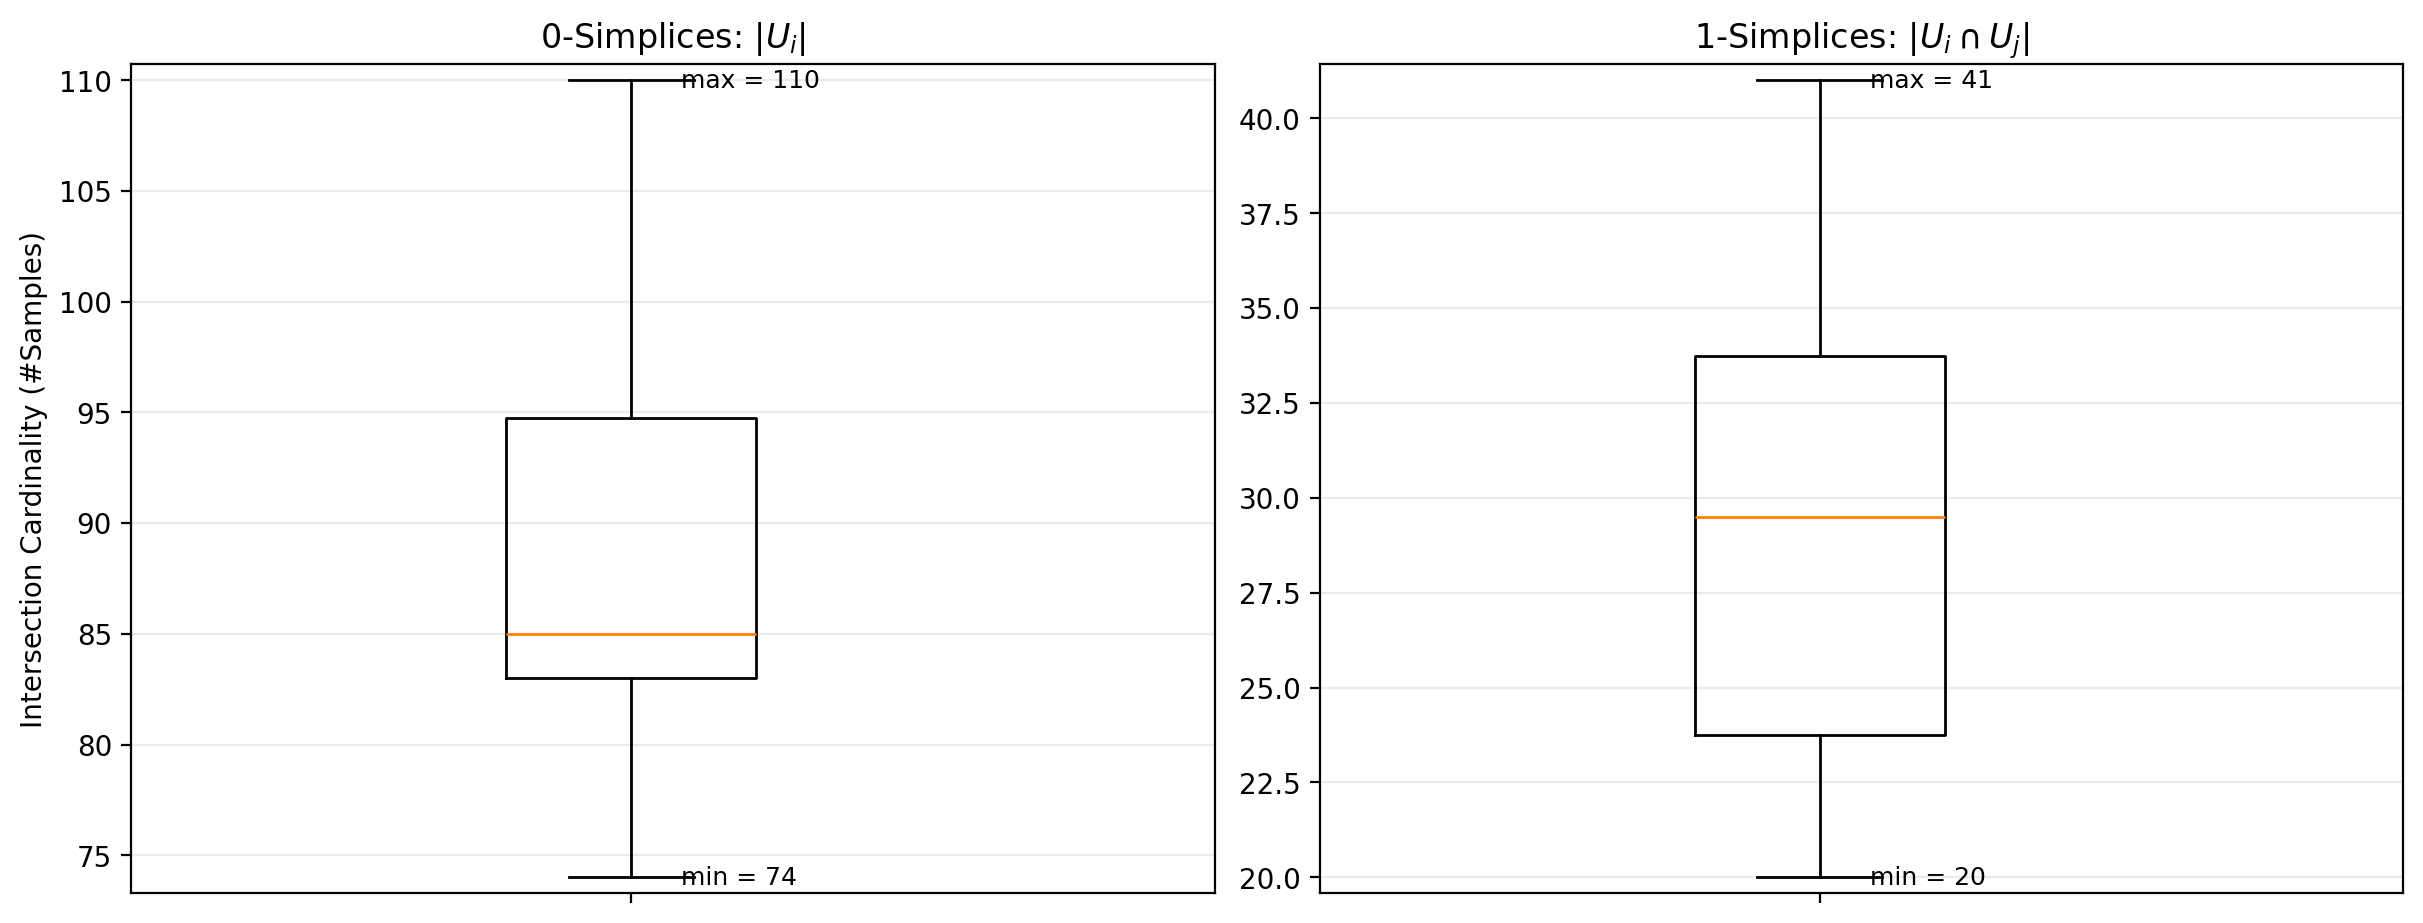

In [51]:
n_landmarks = 12
landmarks = np.linspace(0, np.pi, n_landmarks, endpoint=False)

overlap = 1.5
radius = overlap * np.pi / (2 * n_landmarks)

eq_cover = cb.MetricBallCover(
    eq_base_angles,
    landmarks,
    radius,
    metric=cb.RP1AngleMetric(),
)
eq_cover_data = eq_cover.build()

#Show a summary of the construction
eq_summ = eq_cover.summarize(plot = True)

Compute characteristic classes for the restricted bundle:

In [53]:
eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
    show=True,
)


<IPython.core.display.Math object>

Compute a global 'coordinate system' for the restricted dataset after dropping the heaviest edge from the nerve of the cover of $\mathbb{RP}^{1}$

In [57]:
eq_triv_result = eq_bundle.get_global_trivialization()

Show a visualization of the nerve of the cover of $\mathbb{RP}^{1}$ decorated with edge weights:

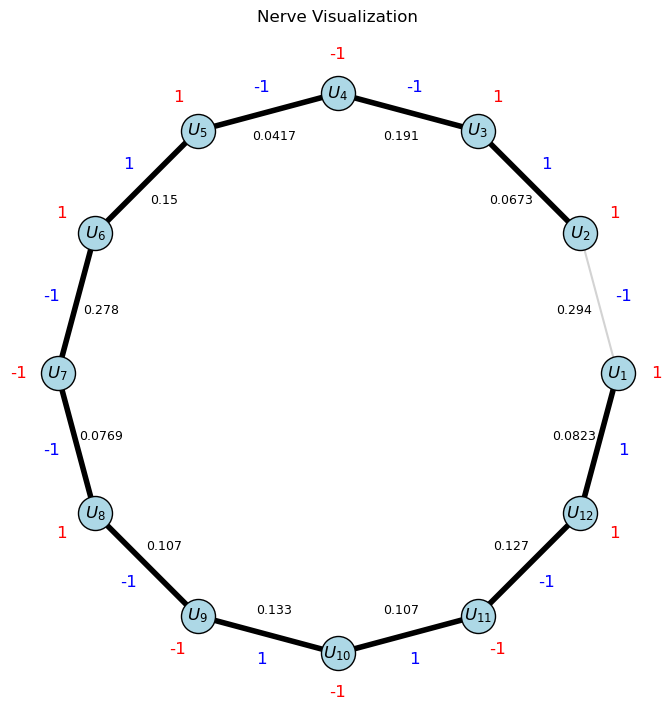

In [58]:
#Compute a potential for the restricted orientation class
eq_subcomplex = eq_bundle.get_max_trivial_subcomplex()
edges = eq_subcomplex.kept_edges
Omega = eq_bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(len(eq_cover.landmarks))}
omega = eq_bundle.classes.omega_O1_used

fig = eq_bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()


The value of the orientation cocycle on each edge is shown in blue, and the removed edge is clearly indicated.  A potential for the cocycle after restriction is shown in red.  

Finally, show a visualization of the coordinatized densities, represented by both the corresponding triangle meshes and 2D projections of the densities themselves:

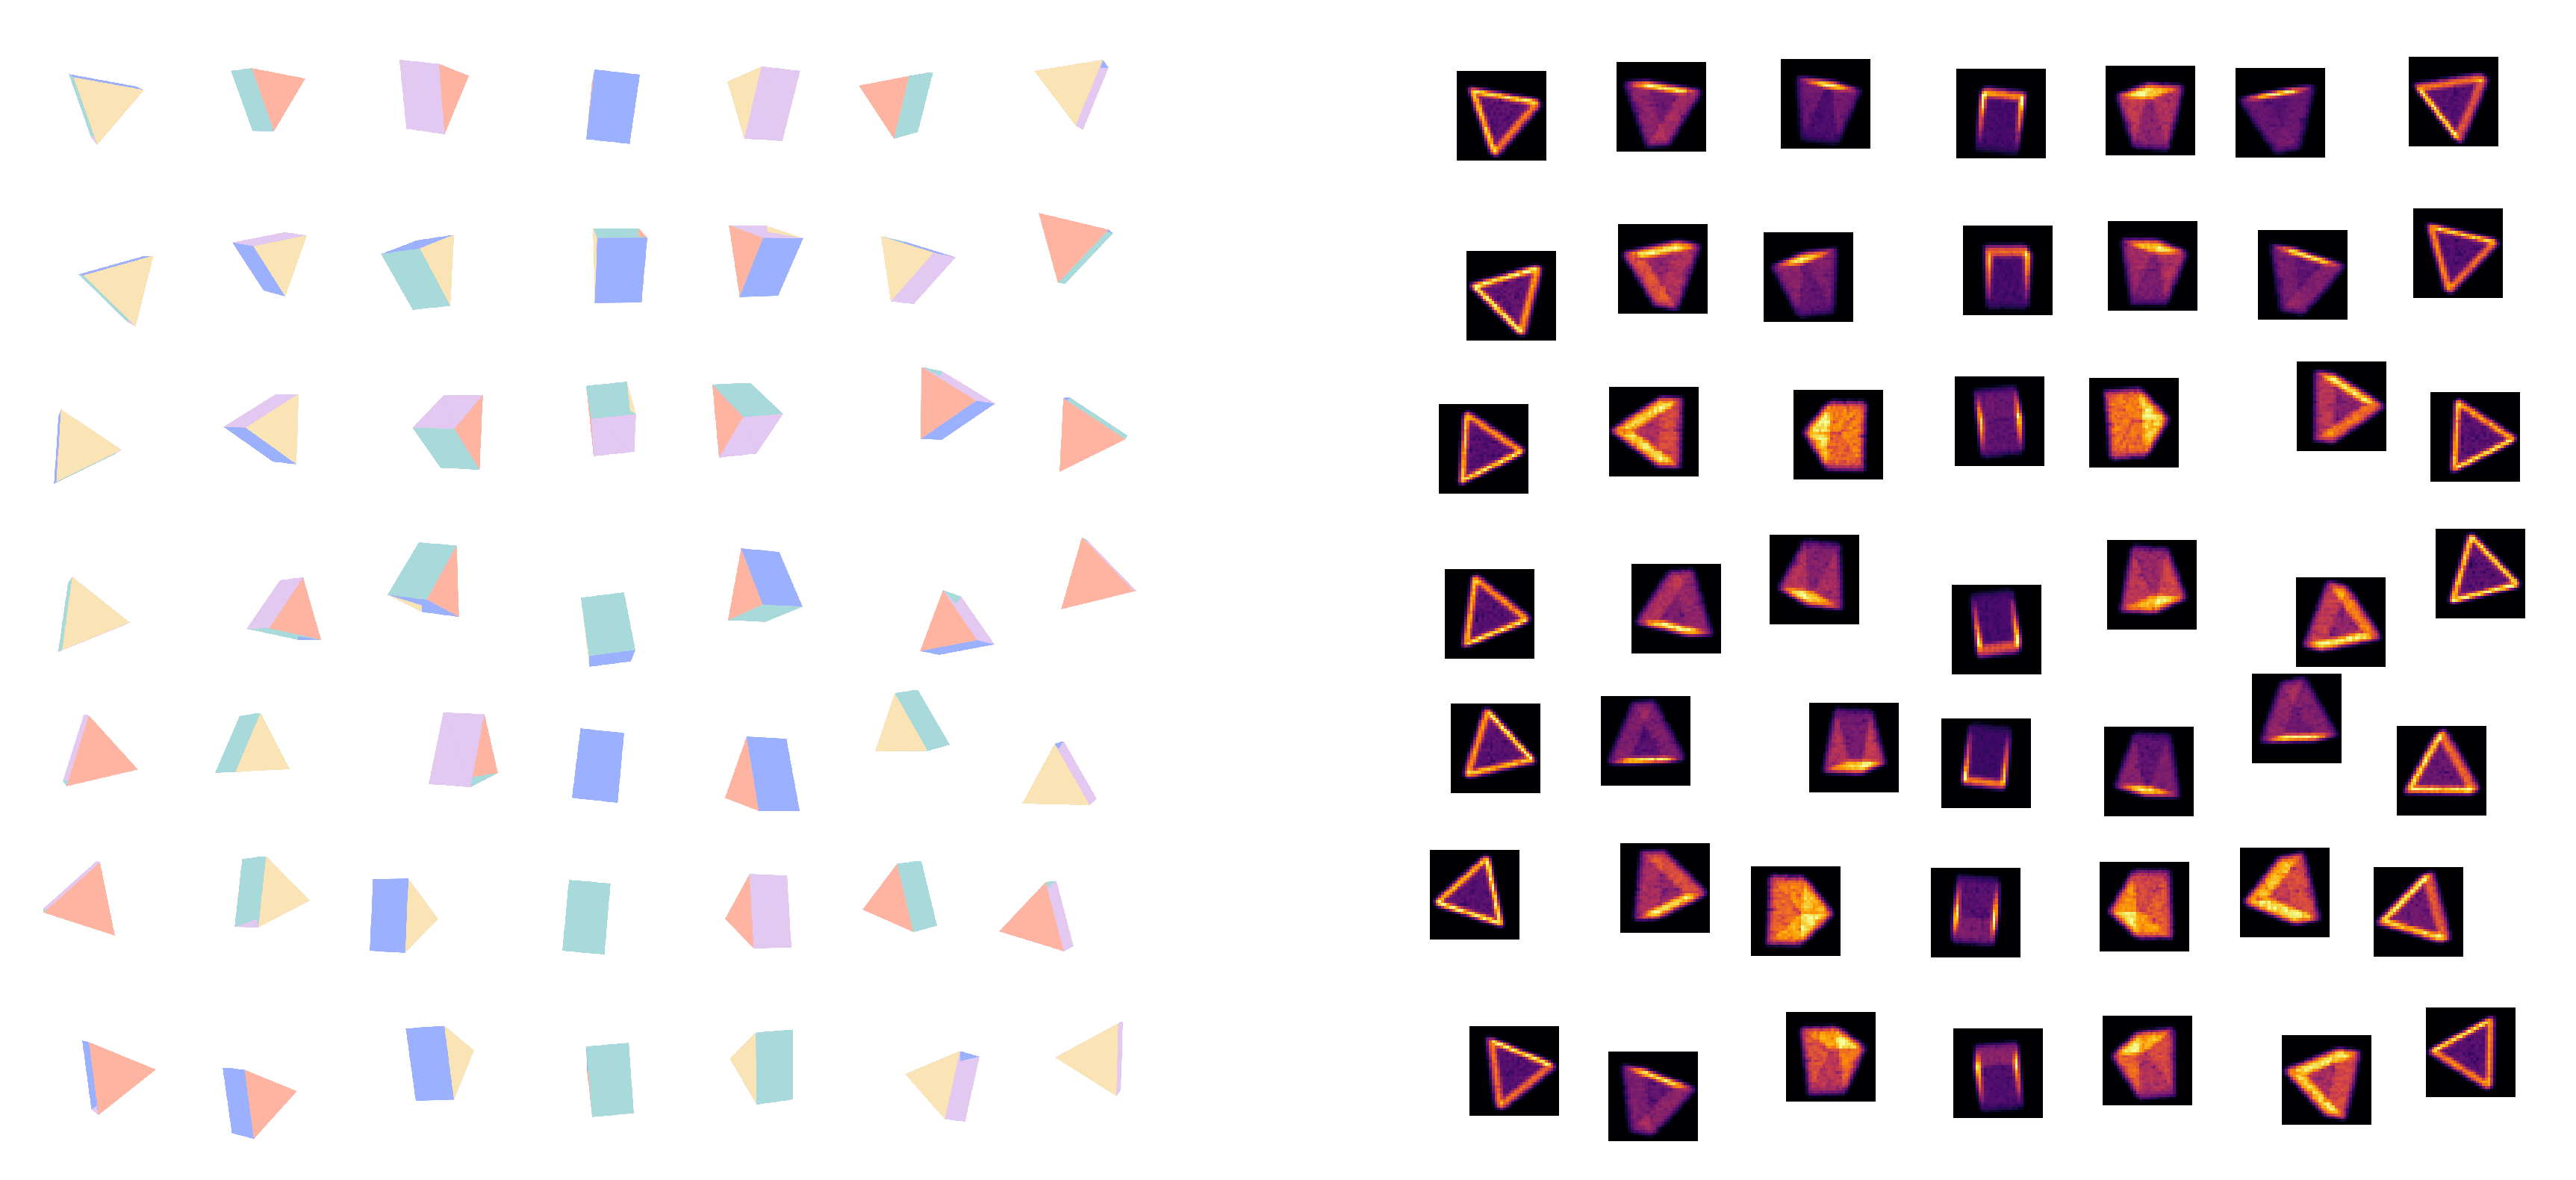

In [56]:
coords = np.column_stack([eq_base_angles, eq_triv_result.F])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), dpi=200)

vz.lattice_vis(
    eq_mesh_data,
    coords,
    vis_mesh,
    per_row=7,
    per_col=7,
    figsize=10,
    thumb_px=100,
    dpi=200,
    ax=ax1,
)

vz.lattice_vis(
    eq_data,
    coords,
    vis_density,
    per_row=7,
    per_col=7,
    figsize=10,
    thumb_px=120,
    dpi=200,
    ax=ax2,
)
plt.show()


Notice that base projection roughly corresponds to axis of symmetry, as expected.  Upon carefuly inspection, one can see that coordinatized densities in each column approximately traverse a 1/3 rotation about the axis of symmetry, but the direction of rotation abruptly changes from counter-clockwise to clockwise between columns 1 and 2. This reflects the fundamental non-orientability of the underlying circle bundle structure over $\mathbb{RP}^{1}$ (in particular, the underlying manifold is a Klein bottle). 